In [1]:
from transformers import BertTokenizer
sentence = "Sitting in a more comfortable car in a different traffic jam is pleasant but hardly the liberation that once seemed to be promised."
tokenizer = BertTokenizer.from_pretrained(r"D:\qxy\pre-trained-model\bert-base-cased")

tokens = tokenizer.tokenize(sentence)
print(tokens)

['sitting', 'in', 'a', 'more', 'comfortable', 'car', 'in', 'a', 'different', 'traffic', 'jam', 'is', 'pleasant', 'but', 'hardly', 'the', 'liberation', 'that', 'once', 'seemed', 'to', 'be', 'promised', '.']


In [5]:
''' step1.生成tokens并用 bert处理'''
def process(text,tokenizer,bert):
    inputs = tokenizer(text,return_tensors='pt')
    #print(inputs)
    output = bert(**inputs,output_attentions=True) # 因为需要输出attention score 的值，所以这里用了 output_attentions 参数
    return output

In [7]:
'''step4.得到某层某个头的attention。【因为attentions 是一个tuple】
01.参数：
output:bert处理后的结果
layer:代表取哪一层的attention
head:代表取哪一head
'''
def getAttention(output,layer,head):
    res = output[2]
    # print(type(res))#
    # print(len(res)) # 12 。解释一下是12的原因：Number of hidden layers in the Transformer encoder 是12
    # print(res) #(tensor()...,tensor()...)

    layer_attention_score = res[layer] # 得到 attention 中的最后一个tuple，也就是最后一层的attention 值
    #print(type(res)) # 去掉一维之后仍然是tuple
    #print(attention_score.size()) # torch.Size([1, 12, 28, 28])。 这个size = [batch_size,num_head,seq_len,seq_len]

    layer_attention_score.squeeze_(0) # 去掉第一维的1
    #print(attention_score.size()) # 因为有12个head，这里只取第一个
    layer_head_attention_score = layer_attention_score[head,:,:]
    #print(layer_head_attention_score.size())
    #print(layer_head_attention_score)
    return layer_head_attention_score

In [ ]:
def getTopWord(first_attention_score):
    #making => 对应的下标是18。所以拿到18这行的行向量
    score = first_attention_score[18].tolist()
    #print(score)

    # 将上面的list转为dict，方便后面根据dict排序，然后找出相似度最高的index
    dic = {}
    for i in range(len(score)):
        dic[i] = score[i]
    #print(dic)

    # 将得到的dic 排序，值高的放在最前面
    res = sorted(dic.items(),key = lambda dic:dic[1],reverse=True)
    res1 = dict(res) # 排序后是list，再转为dict
    keys = res1.keys()
    #print(keys)

    # 得到tokens的id，并转为list
    tokens = inputs['input_ids'].squeeze_(0).tolist()
    i= 0
    for _ in keys:# 将token转换成相应的word
        if i < 5:
            print(tokenizer.convert_ids_to_tokens( tokens[_]))
            i+=1
        else:
            break

In [2]:
#print(first_attention_score)
'''可视化attention 的结果
01.可视化某个head
02.或者把所有的head平均下来看看
'''
def drawAttention(inputs,first_attention_score):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.ticker as ticker
    import torch

    #将first_attention_score 的grad属性去除 => 使用detach()，并转为numpy
    res2 = first_attention_score.detach().numpy()
    temp = inputs["input_ids"][0] # 得到input_ids，为了将其转换成tokens
    #print(temp)
    tokens= tokenizer.convert_ids_to_tokens(temp)
    #print(type(tokens)) #
    #print(tokens) # ['[CLS]', 'it', 'is', ...]

    # tokens就是我们的横纵坐标(标签)
    df = pd.DataFrame(res2, columns=tokens, index=tokens)
    fig = plt.figure(figsize = (10,10))# 画图，这里调整了图片的大小，否则会因为word太长导致文字重叠
    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(df, interpolation='nearest', cmap='hot_r')
    fig.colorbar(cax)

    tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels([''] + list(df.columns))
    ax.set_yticklabels([''] + list(df.index))
    name = "./"+str(head)+".png"
    #plt.savefig(name) # 存储图片
    plt.show()

Some weights of the model checkpoint at D:\qxy\pre-trained-model\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
D:\qxy\software-ide\ana\envs\torch-cpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used t

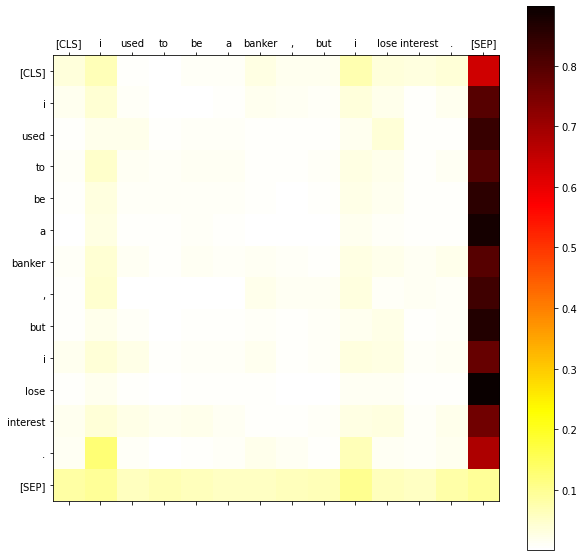

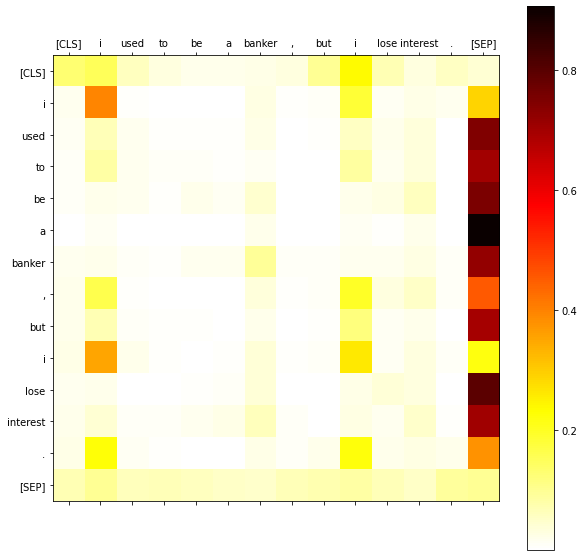

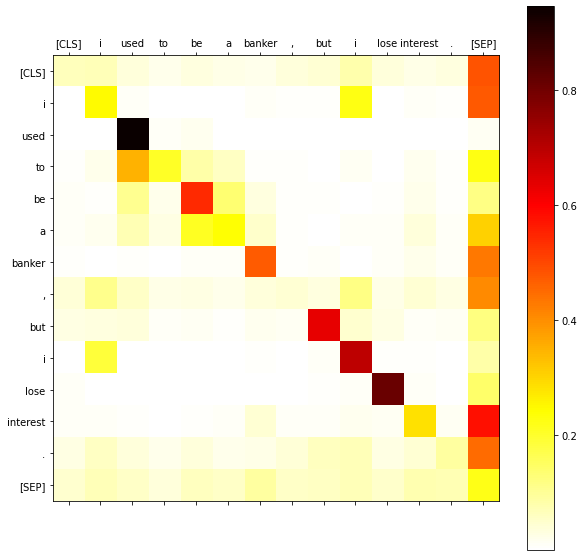

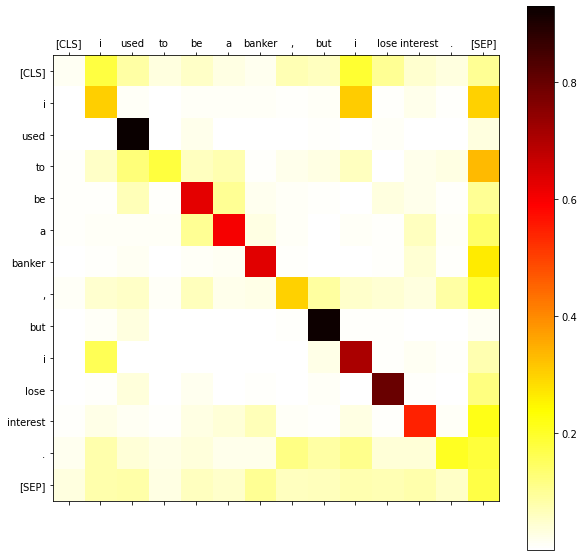

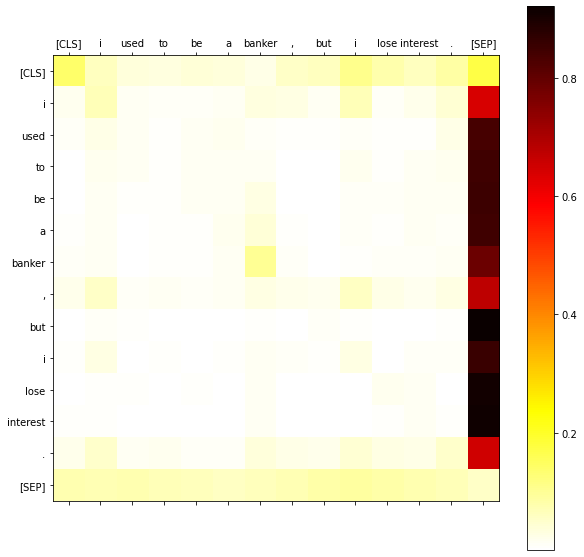

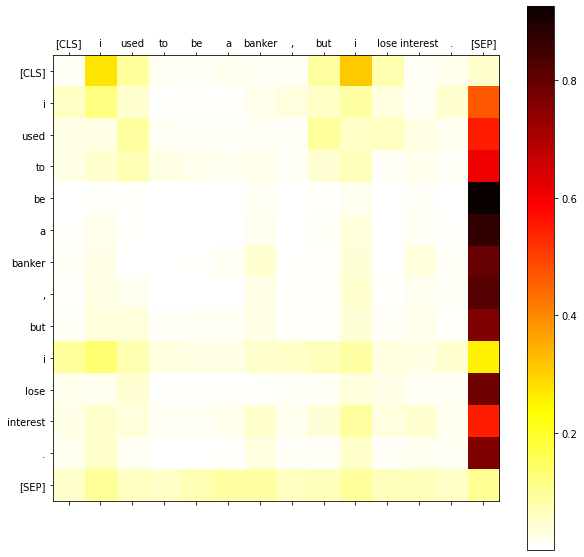

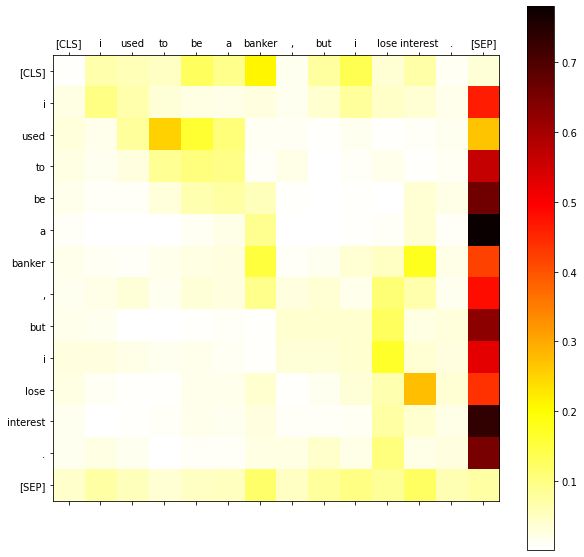

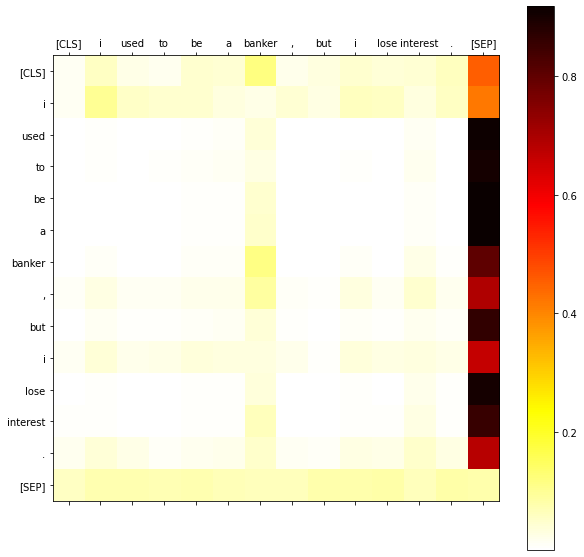

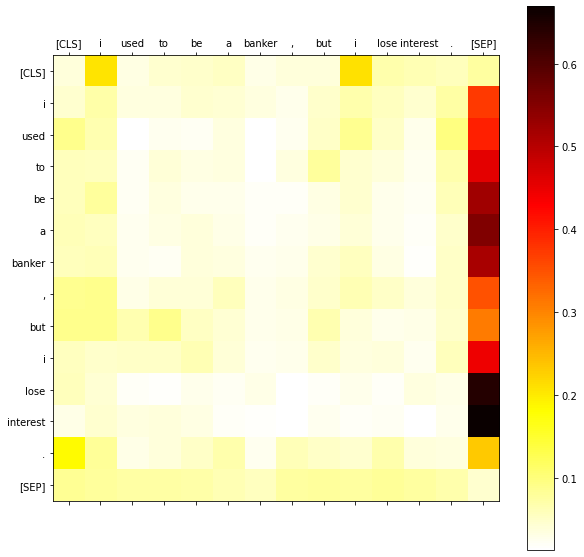

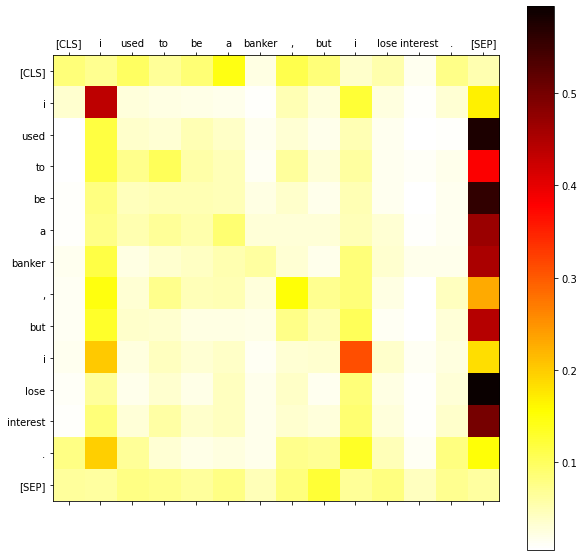

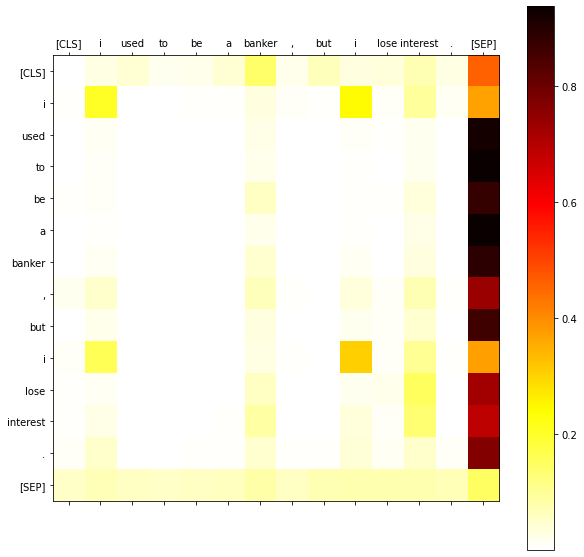

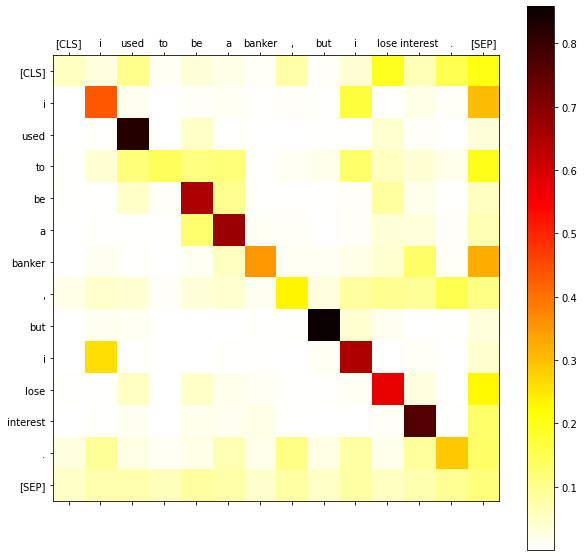

In [8]:
import torch as t
from transformers import BertModel,AutoTokenizer
import matplotlib.pyplot as plt
tokenizer = BertTokenizer.from_pretrained(r"D:\qxy\pre-trained-model\bert-base-cased")
bert = BertModel.from_pretrained(r"D:\qxy\pre-trained-model\bert-base-cased")
#text ="It is in this spirit that a majority of American governments have passed new laws since 2008 making the registration or voting process more difficult."
text = "Sitting in a more comfortable car in a different traffic jam is pleasant but hardly the liberation that once seemed to be promised."
layer = 11
head=2
#figure = plt.figure(30,30)
output = process(text,tokenizer,bert)

# print(text)
# print(output)

# 根据每个head，画出一张attention图
for head in range(12):
    layer_head_attention_score = getAttention(output,layer,head)
    inputs = tokenizer(text,return_tensors='pt')
    drawAttention(inputs,layer_head_attention_score)